In [1]:
%load_ext autoreload
%autoreload 2

import sys
import math
import pickle 
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score
from sklearn.inspection import PartialDependenceDisplay

from warnings import simplefilter
simplefilter('ignore')

sys.path.append('../')

from src.training.bankmarketing import *

## Train on full data

In [2]:
bmfull = BankMarketingModel()
bmfull.train_bank_model()

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


In [3]:
bmfull.print_metrics()

ROC AUC train :  0.7664629014914208 
 ROC AUC val :  0.721882153876779 
 ROC AUC test :  0.7489543198956569 

Precision test :  0.43548387096774194
Recall test :  0.5934065934065934


## Train without campaign features

In [4]:
bmred = BankMarketingModel(full=False)
bmred.train_bank_model()

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


In [5]:
bmred.print_metrics()

ROC AUC train :  0.7545964046940016 
 ROC AUC val :  0.6638424405295112 
 ROC AUC test :  0.7096232553258475 

Precision test :  0.5753424657534246
Recall test :  0.46153846153846156


## Compare results

In [6]:
roc_auc_diff = np.round(roc_auc_score(bmfull.y_test, bmfull.grid_pipe_lgbm.predict(bmfull.X_test_enc)) 
                - roc_auc_score(bmred.y_test, bmred.grid_pipe_lgbm.predict(bmred.X_test_enc)), 3)

print(f"""Adding campaign related features to the model results in {roc_auc_diff} increase in ROC AUC score""")

Adding campaign related features to the model results in 0.039 increase in ROC AUC score


In [7]:
get_roc_auc_diff(bmfull, bmred)

Adding campaign related features to the model results in 0.039 increase in ROC AUC score


## Feature importance

In [36]:
bmfull.get_fimp()

TypeError: get_fimp() takes 1 positional argument but 2 were given

Campaign feature is in the top. 

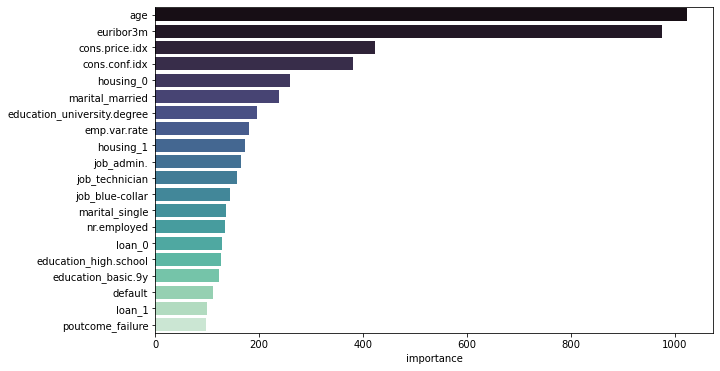

In [9]:
bmred.get_fimp()

## pdp

In [18]:
bmfull.X_train_enc.columns

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'housing_0', 'housing_1', 'housing_unknown',
       'loan_0', 'loan_1', 'loan_unknown', 'contact_cellular',
       'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'pdays', 

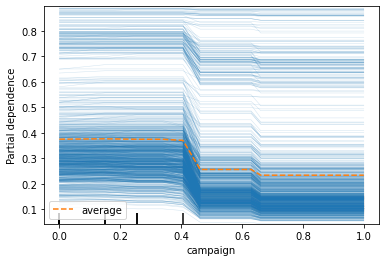

In [28]:
PartialDependenceDisplay.from_estimator(bmfull.grid_pipe_lgbm, bmfull.X_train_enc, 
            [list(bmfull.X_train_enc.columns).index('campaign')], kind='both',
        ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
      pd_line_kw={"color": "tab:orange", "linestyle": "--"});

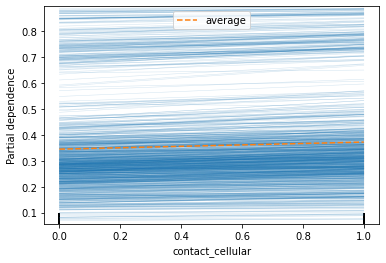

In [30]:
PartialDependenceDisplay.from_estimator(bmfull.grid_pipe_lgbm, bmfull.X_train_enc, 
            [list(bmfull.X_train_enc.columns).index('contact_cellular')], kind='both',
            ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
      pd_line_kw={"color": "tab:orange", "linestyle": "--"});

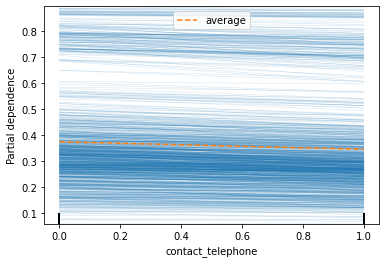

In [27]:
PartialDependenceDisplay.from_estimator(bmfull.grid_pipe_lgbm, bmfull.X_train_enc, 
     [list(bmfull.X_train_enc.columns).index('contact_telephone')], 
      kind='both',
      ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
      pd_line_kw={"color": "tab:orange", "linestyle": "--"});

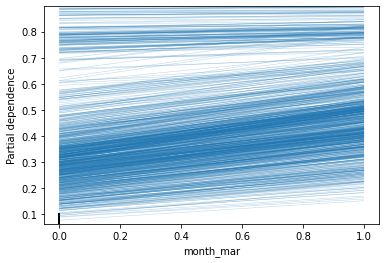

In [24]:
PartialDependenceDisplay.from_estimator(bmfull.grid_pipe_lgbm, bmfull.X_train_enc, 
     [list(bmfull.X_train_enc.columns).index('month_mar')], kind='individual');

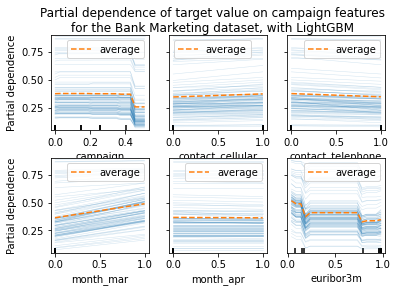

In [40]:
features = ["campaign", "contact_cellular", "contact_telephone", 
            "month_mar", "month_apr", 'euribor3m']
display = PartialDependenceDisplay.from_estimator(
    bmfull.grid_pipe_lgbm,
    bmfull.X_train_enc,
    features,
    kind="both",
    subsample=100,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
display.figure_.suptitle(
    "Partial dependence of target value on campaign features\n"
    "for the Bank Marketing dataset, with LightGBM"
)
display.figure_.subplots_adjust(hspace=0.3)